### Generative-Adversarial-Network

In [1]:
%matplotlib inline 

import pickle as pkl
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 

# load dataset 
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Model Inputs 
+ create the inputs for our graph. Two inputs, one for discriminator and one for generator 
+ call the discriminator input: input_real ; the generator input: input_z 

In [2]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name = 'input_real') # None - batch size 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'intput_z')
    return inputs_real, inputs_z

Use leaky RElU as hidden layer. A leaky RELU like a normal ReLU, except that there is a small non-zero output for negatie input values range between -1 and 1 

In [3]:
def generator(z, out_dim, n_units = 128, reuse = False, alpha =.01):
    with tf.variable_scope('generator', reuse = reuse):
        # hidden layer
        h1 = tf.layers.dense(z, n_units, activation = None)
        # leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # logits and tanh output 
        logits = tf.layers.dense(h1, out_dim, activation = None)
        out = tf.tanh(logits)
        
        return out 

In [4]:
# The discriminator network is almost exactly the same as the generator netowork, except that we are using a sigmoid output layer 
def discriminator(x, n_units = 128, reuse=False, alpha = 0.01):
    with tf.variable_scope('discriminator', reuse = reuse):
        # hidden layer 
        h1 = tf.layers.dense(x, n_units, activation = None)
        # leaky Relu
        h1 = tf.maximum(alpha * h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation = None)
        out = tf.sigmoid(logits) # probability for distinguishing whether it is fake or real 
        
        return out, logits 

### hyperparameters 

In [5]:
# hyperparameters 
## size of input image to discriminator 
input_size = 784
## size of latent vector to generator 
z_size = 100
## size of hidden layers in generator and discriiminator 
g_hidden_size = 128 
d_hidden_size = 128 

# leak factor for leaky ReLu
alpha = 0.01 
# smoothing 
smooth = 0.01 

### Build network 
+ First, get input_real, input_z from model_inputs using the size of input and z 
+ Create generator
+ Then, discriminator 
+ Want the weights to be the same for both real and fake data, we need to reuse the variables. 

In [6]:
tf.reset_default_graph()
# create our input placeholders 
input_real, input_z = model_inputs(input_size, z_size)

# build the model 
g_model = generator(input_z, input_size, n_units = g_hidden_size, alpha = alpha)
# g_model is the generator output 

d_model_real, d_logits_real = discriminator(input_real, n_units = d_hidden_size, alpha = alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse = True, n_units = d_hidden_size, alpha = alpha)

### Discriminator and generator losses 
+ for the discriminator, the total loss is the sum of the losses for real and fake images. d_loss = d_loss_real+d_loss_fake
+ the losses will be sigmoid cross-entropys, which we can get the tf.nn.sigmoid_cross_entropy_with_logist
+ wrap that in t.reduced_mean to get the mean for all the images in the batch.        
+ for the real images, we'll use d_logits_real which we got from the discriminator in the cell above. For the labels, we want
+ them to be all ones, since there are all real images. To help the discriminator generalize better,the labels are reduced a bit from 
+ 1.0 to 0.9 -- label smoothing 
        
+ the generator losses are using d_logits_fake, the fake image logits. But now the labels are all ones. 

In [7]:
# calcualte losses 
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits =d_logits_real,
                                                                     labels = tf.ones_like(d_logits_real) * (1 - smooth)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                     labels = tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                labels = tf.ones_like(d_logits_fake)))

### Optimizier
+ update the generator and discriminator variables separately. 
+ get the variables for each part bild optimizers for the two parts 
+ tf.trainable_variables() --> creates a list of all the variables we have defined in our graph 

In [8]:
# optimizers 
learning_rate = 0.002
# get the trainable_variables, split into G and D parts 
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list = d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list = g_vars)

In [30]:
# training 
batch_size = 100 
epochs = 100 
samples = []
losses = []

In [31]:
# only save generator variables 
saver = tf.train.Saver(var_list = g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples // batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            # get images, reshape and rescale to pass to D 
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 -1 
            
            # sample random noise for G 
            batch_z = np.random.uniform(-1,1,size = (batch_size, z_size))
            
            # run optimizers 
            _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z:batch_z})
            _ = sess.run(g_train_opt, feed_dict = {input_z:batch_z})
            
            
            # at the end of each epoch, get the losses and print them out 
            train_loss_d = sess.run(d_loss, {input_z:batch_z,input_real : batch_images})
            train_loss_g = g_loss.eval(feed_dict ={input_z:batch_z})
            
            
        print('Epoch {} /{} ...'.format((e+1), epochs),
              'Discriminator Loss: {:.4f}...'.format(train_loss_d),
              'Generator Loss: {:.4f}...'.format(train_loss_g))
            
            # save losses to view after training 
        losses.append((train_loss_d, train_loss_g))
            
            # sample from generator as we are training for viewing afterwards 
        sample_z = np.random.uniform(-1,1, size = (16, z_size))
        gen_samples =  sess.run(
                 generator(input_z, input_size, n_units = g_hidden_size, reuse = True, alpha = alpha), feed_dict = {input_z : sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

Epoch 1 /100 ... Discriminator Loss: 0.0899... Generator Loss: 4.3691...
Epoch 2 /100 ... Discriminator Loss: 0.1096... Generator Loss: 3.9508...
Epoch 3 /100 ... Discriminator Loss: 1.2423... Generator Loss: 0.8787...
Epoch 4 /100 ... Discriminator Loss: 1.1164... Generator Loss: 0.9400...
Epoch 5 /100 ... Discriminator Loss: 0.9199... Generator Loss: 5.0913...
Epoch 6 /100 ... Discriminator Loss: 1.8711... Generator Loss: 0.7625...
Epoch 7 /100 ... Discriminator Loss: 0.9845... Generator Loss: 2.0451...
Epoch 8 /100 ... Discriminator Loss: 2.0665... Generator Loss: 1.4758...
Epoch 9 /100 ... Discriminator Loss: 1.7115... Generator Loss: 0.7870...
Epoch 10 /100 ... Discriminator Loss: 2.0176... Generator Loss: 1.3564...
Epoch 11 /100 ... Discriminator Loss: 1.1028... Generator Loss: 2.4827...
Epoch 12 /100 ... Discriminator Loss: 1.8510... Generator Loss: 6.9937...
Epoch 13 /100 ... Discriminator Loss: 5.3782... Generator Loss: 1.7062...
Epoch 14 /100 ... Discriminator Loss: 2.7527...

In [32]:
# save training generator samples 
with open('train_sample.pkl','wb') as f:
    pkl.dump(samples,f)

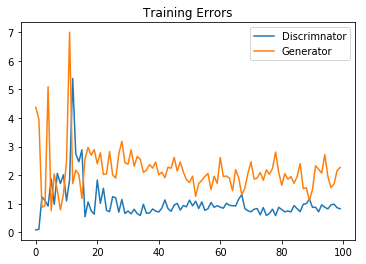

In [33]:
# Training loss 
## check out the training loss for the generator and discriminator 
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],label = 'Discrimnator')
plt.plot(losses.T[1], label = 'Generator')
plt.title('Training Errors')
plt.legend()
plt.show()

In [34]:
# Generator samples from training 
def view_samples(epoch, samples):
    fig, ax = plt.subplots(figsize = (7,7), nrows = 4, ncols = 4, sharex=True, sharey=True)
    for ax, img in zip(ax.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)),cmap = 'Greys_r')
        
    return fig, ax

In [35]:
# load samples from generator token while training 
with open('train_sample.pkl','rb') as f:
    samples = pkl.load(f)

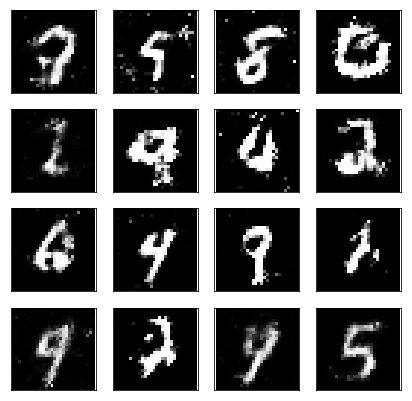

In [36]:
_=view_samples(-1, samples)

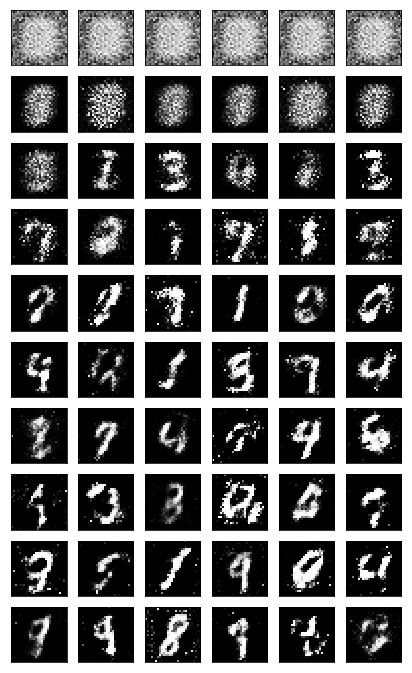

In [37]:
# show the generated images as the network was training, every 10 epoches 
rows, cols = 10 , 6
fig, axes = plt.subplots(figsize = (7,12),nrows = rows, ncols = cols, sharex=True, sharey = True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)],ax_row):
        ax.imshow(img.reshape((28,28)),cmap = 'Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)